In [1]:
import os
import pickle
import itertools
import pandas as pd
import numpy as np
import modelgym
from modelgym.util import TASK_CLASSIFICATION
from modelgym.trainer import Trainer
from modelgym import ProgressTracker
from sklearn.metrics import roc_auc_score
from hyperopt.mongoexp import MongoTrials
from modelgym.util import split_and_preprocess

########### NROWS, N_ESTIMATORS, N_PROBES, TEST_SIZE, N_CV_SPLITS, OPTIMIZER
config_tuple = {
    'test': (1000, 10,  2, 0.5, 2, 'random'),
    'pror': (None, 1000, 100, 0.5, 2, 'random'), # production with random hyperopt suggestor
    'prot': (None, 1000, 100, 0.5, 2, 'tpe'),    # production with tpe hyperopt suggestor
    'demi': (10000, 100, 5, 0.5, 2, 'random')
}
CONFIG = 'test' if 'EXP_CONFIG' not in os.environ else os.environ['EXP_CONFIG']
NROWS, N_ESTIMATORS, N_PROBES, TEST_SIZE, N_CV_SPLITS, OPTIMIZER = config_tuple[CONFIG]
EXP_KEYS = ['xgb', 'lgb'] # which experiments to run, order is important for report
EXP_NAMES = {
    'xgb': (modelgym.XGBModel), 
    'lgb': (modelgym.LGBModel),
}
RESULTS_DIR = "results"
LOAD_CACHE = False
is_mongo = False

In [2]:
print "Running experiment cofiguration:", CONFIG

Running experiment cofiguration: test


In [3]:
%%bash 
if [ ! -d data ] ; then 
    mkdir data 
    cd data
    curl https://cernbox.cern.ch/index.php/s/N1dpSAPgl30szYM/download | gunzip -c > XY2d.pickle
fi
ls -l data

total 133116
-rw-r--r-- 1 root root 136304022 Jun 11 00:12 XY2d.pickle


In [4]:
%%time
def read_commented_head(fname, nrows=None):
    with open(fname) as fh:
        X, y = pickle.load(fh)
    index = np.arange(X.shape[0])
    index_perm = np.random.permutation(index)
    if nrows is None:
        nrows = X.shape[0]
    return X[index_perm[:nrows]], y[index_perm[:nrows]], np.ones(nrows)


X, y, weights = read_commented_head("data/XY2d.pickle", nrows=NROWS)


CPU times: user 860 ms, sys: 184 ms, total: 1.04 s
Wall time: 1.04 s


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, weights, test_size=TEST_SIZE)

In [6]:
cat_cols = []
cv_pairs, (dtrain, dtest) = split_and_preprocess(X_train.copy(), y_train, 
                                                X_test.copy(), y_test, 
                                                cat_cols, n_splits=N_CV_SPLITS)

In [7]:
if 'MONGO_PORT_27017_TCP_ADDR' in os.environ:
    host = os.environ['MONGO_PORT_27017_TCP_ADDR'] if 'MONGO_PORT_27017_TCP_ADDR' in os.environ else 'cern-mc01h'
    port = int(os.environ['MONGO_PORT_27017_TCP_PORT']) if 'MONGO_PORT_27017_TCP_PORT' in os.environ else 27017
    db = os.environ['MONGO_DB'] if 'MONGO_DB' in os.environ else 'trials'

    for exp in EXP_KEYS:
        trials[exp] = MongoTrials('mongo://%s:%d/%s/jobs' % (host, port, db), exp_key=exp)

## Run them all

In [12]:
trackers = {}
def init_exp_dict():
    return dict([(k, None) for k in EXP_KEYS])
default_cv_result = init_exp_dict()
tuned_cv_result = init_exp_dict()
default_test_result = init_exp_dict()
tuned_test_result = init_exp_dict()
trials = init_exp_dict()
trainer = Trainer(hyperopt_evals=N_PROBES)

In [14]:
for exp in EXP_KEYS:
    model_class = EXP_NAMES[exp]
    model = model_class(TASK_CLASSIFICATION, n_estimators=N_ESTIMATORS)
    print model.get_name()
    trackers[exp] = ProgressTracker(model, CONFIG, RESULTS_DIR)
    if LOAD_CACHE:
        default_cv_result[exp], default_test_result[exp], tuned_cv_result[exp], tuned_test_result[exp], trials[exp] = \
            trackers[exp].load_state(as_list=True)
    
    
    if default_cv_result[exp] is None:
        default_cv_result[exp] = trainer.crossval_fit_eval(model, cv_pairs)
        trackers[exp].save_state(default_cv=default_cv_result)
    trainer.print_result(default_cv_result[exp], 'Default {} result on CV'.format(model.get_name()))

    if default_test_result[exp] is None:
        default_test_result[exp] = trainer.fit_eval(model, dtrain, dtest,
                                                  default_cv_result[exp]['params'],
                                                  default_cv_result[exp]['best_n_estimators'],
                                                  custom_metric = {'roc_auc': roc_auc_score})
        trackers[exp].save_state(default_test=default_test_result)

    trainer.print_result(default_test_result[exp], 'Default {} result on TEST'.format(model.get_name()), extra_keys=['roc_auc'])

        
    if tuned_cv_result[exp] is None:
        print('Hyperopt iterations:\n\n')
        tuned_cv_result[exp] = trainer.crossval_optimize_params(model, cv_pairs,  algo_name=OPTIMIZER, 
                                                           trials=trials[exp], tracker=trackers[exp])
        trackers[exp].save_state(tuned_cv=tuned_cv_result)
    trainer.print_result(tuned_cv_result[exp], 'Tuned {} result on cv'.format(model.get_name()))

    if tuned_test_result[exp] is None:
        tuned_test_result[exp] = trainer.fit_eval(model, dtrain, dtest,
                                            tuned_cv_result[exp]['params'],
                                            tuned_cv_result[exp]['best_n_estimators'],
                                            custom_metric = {'roc_auc': roc_auc_score})
        trackers[exp].save_state(tuned_test=tuned_test_result)
    trainer.print_result(tuned_test_result[exp], 'Tuned {} result on test'.format(model.get_name()), extra_keys=['roc_auc'])

    trackers[exp].save_state(default_cv=default_cv_result[exp], default_test=default_test_result[exp], 
                               tuned_cv=tuned_cv_result[exp], tuned_test=tuned_test_result[exp], trials=trials[exp])
    

XGBoost
Default XGBoost result on CV:

loss = 0.428568
best_n_estimators = 25
params = {'reg_alpha': 0, 'eval_metric': 'logloss', 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.1, 'max_delta_step': 0, 'base_score': 0.5, 'n_estimators': 100, 'seed': 0, 'colsample_bytree': 1, 'silent': 1, 'missing': None, 'nthread': -1, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'objective': 'binary:logistic', 'max_depth': 3, 'gamma': 0}
Default XGBoost result on TEST:

loss = 0.416771
n_estimators = 25
params = {'reg_alpha': 0, 'eval_metric': 'logloss', 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.1, 'max_delta_step': 0, 'base_score': 0.5, 'n_estimators': 100, 'seed': 0, 'colsample_bytree': 1, 'silent': 1, 'missing': None, 'nthread': -1, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'objective': 'binary:logistic', 'max_depth': 3, 'gamma': 0}
roc_auc = 0.812603
Hyperopt iterations:


[1/2]	eval_time=3.02 sec	current_logloss=0.412667	min_loglo

## Compare

In [16]:
test_results_list = []
metric, mes_min = 'roc_auc', False

index = EXP_KEYS
names = ['XGBoost', 'LightGBM'] # TODO make hash
full_results = {}
for i in index:
    if i in trackers:
        tracker = trackers[i]
    else:
        tracker = ProgressTracker(i, CONFIG, RESULTS_DIR)
        tracker.load_state()
    full_results.update({i:{'tuned': tracker.state['tuned_test'], 'default': tracker.state['default_test']}})
    test_results_list.append([tracker.state['default_test'][metric], tracker.state['tuned_test'][metric]])
test_results = np.array(test_results_list)

baseline = test_results.max() if metric == 'roc_auc' else test_results.min()
diff = 100 * (test_results / baseline - 1)

res = [['{:.6f} ({:+.2f}%)'.format(test_results[i, j], diff[i, j]) for j in range(2)] for i in range(len(index))]

pd.DataFrame(res, columns=['default', 'tuned'], index=index)

,default,tuned
xgb,0.812603 (-1.48%),0.822221 (-0.31%)
lgb,0.799582 (-3.05%),0.824773 (+0.00%)


Populating the interactive namespace from numpy and matplotlib


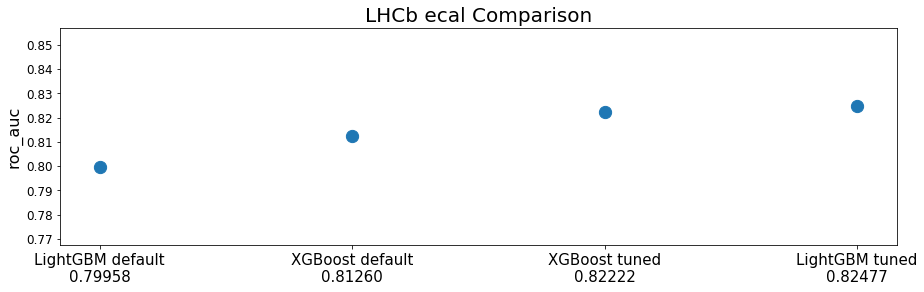

In [17]:
%pylab inline --no-import-all

full_names = [" ".join(i) for i in itertools.product(names, ['default', 'tuned'])]
named_results = zip(full_names, test_results.flatten())
sorted_results = sorted(named_results, key=lambda x: x[1])
xticks = ['%s\n%.5f' % (name, loss) for name, loss in sorted_results]

plt.figure(figsize=(15, 4))
plt.scatter(range(2*len(index)), zip(*sorted_results)[1], s=150)
plt.xticks(range(2*len(index)), xticks, fontsize=15)
plt.yticks(fontsize=12)
plt.title('LHCb ecal Comparison', fontsize=20)
plt.ylabel(metric, fontsize=16);